In [1]:
import tensorflow as tf
print (tf.__version__)

2.4.0


In [2]:
tf.keras.backend.clear_session()

In [3]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import ZeroPadding2D

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
project_path = '/content/drive/My Drive/DogBreed_Classification/'

In [6]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip','r') as z:
  z.extractall()

In [8]:
from zipfile import ZipFile
with ZipFile(project_path+'test.zip','r') as z:
  z.extractall()

In [9]:
submission = pd.read_csv(project_path+'sample_submission.csv.zip')
test_img = submission['id']
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [7]:
labels = pd.read_csv(project_path+'labels.csv.zip')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
breed_count=labels['breed'].value_counts()
breed_count.head()

In [ ]:
targets = pd.Series(labels['breed'])
one_hot = pd.get_dummies(targets)
one_hot_labels = np.asarray(one_hot)

encoder = LabelEncoder()
label = encoder.fit_transform(labels['breed'])
y_label=tf.keras.utils.to_categorical(label, num_classes=None, dtype='int')#, 120)

In [10]:
IMG_SIZE=128
channels=1
EPOCHS=100
BATCH=100

In [11]:
x_features=[]
y_feature=[]
#label=[]

i=0
for f, img in tqdm(labels.values): #f for image id, img for dog breed
  #Using cv2.imread results in BGR images, instead of the standard RGB as below
  train_img = cv2.imread('./train/{}.jpg'.format(f),0) #0 for grayscale & 1 for color (o/p is bgr)
  train_img_resize = cv2.resize(train_img, (IMG_SIZE,IMG_SIZE))
  label = one_hot_labels[i]
  x_features.append(train_img_resize)
  y_feature.append(label)
  i+=1
  #label.append(img)

100%|██████████| 10222/10222 [00:13<00:00, 778.07it/s]


In [ ]:
x_test_feature=[]
i=0
for f in tqdm(test_img.values):
    img = cv2.imread('./test/{}.jpg'.format(f),0)
    img_resize = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    x_test_feature.append(img_resize)

In [13]:
x_train_data = np.array(x_features,np.float32) / 255.0  #Division by 255. for normalisation
print(x_train_data.shape)
x_train_data = np.expand_dims(x_train_data, axis=3)
print(x_features.shape)

#y_label = np.array(y_label)
#print(y_label.shape)
y_train_data = np.array(y_feature)
print(y_train_data)

(10222, 128, 128, 1)
(10222, 120)


In [ ]:
x_test_data = np.array(x_test_feature,np.float32) / 255.0  #Division by 255. for normalisation
print(x_test_data.shape)
x_test_data = np.expand_dims(x_test_data, axis=3)
print(x_features.shape)

In [14]:
x_train,x_val,y_train,y_val=train_test_split(x_train_data,y_train_data,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_val.shape)

(8177, 128, 128, 1)
(2045, 128, 128, 1)


In [15]:
model1 = Sequential()
model1.add(Conv2D(32,(5,5),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels)))
model1.add(Conv2D(filters=64, kernel_size=4, padding='same',activation='relu'))
model1.add(Conv2D(128, kernel_size=3, padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=3))
#model1.add(Dropout(0.2))
#model1.add(Conv2D(filters=64, kernel_size=4, padding='same',activation='relu'))
#model1.add(MaxPooling2D(pool_size=2))
#model1.add(Dropout(0.2))
#model1.add(Conv2D(128, kernel_size=3, padding='same',activation='relu'))
#model1.add(MaxPooling2D(pool_size=2))
#model1.add(Dropout(0.8))
model1.add(Conv2D(128, kernel_size=2, padding='same',activation='relu'))
model1.add(Conv2D(128, kernel_size=2, padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=2))
#model1.add(Dropout(0.8))
model1.add(Flatten())
#fully connected layer
model1.add(Dense(units=500,activation='relu'))
model1.add(Dropout(0.8))
#output layer
model1.add(Dense(units=120,activation='softmax'))

In [16]:
optimizer=Adam(lr=0.01)
model1.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 41, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 128)       0

In [17]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('dogbreed_cnn.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max',
                                                    min_delta=0.001,
                                                    patience=5,
                                                    verbose=1)
model_es=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.001,patience=5,mode='max',verbose=1)
model_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.01,patience=5,verbose=1,mode='auto',min_delta=0.0001)

In [18]:
history = model1.fit(x_train, y_train,
                     batch_size=BATCH,
                     epochs=EPOCHS,
                     validation_data=(x_val,y_val),
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/100
82/82 [==============================] - 6s 44ms/step - loss: 4.9582 - accuracy: 0.0084 - val_loss: 4.7836 - val_accuracy: 0.0093

Epoch 00001: val_accuracy improved from -inf to 0.00929, saving model to dogbreed_cnn.h5
Epoch 2/100
82/82 [==============================] - 3s 36ms/step - loss: 4.7804 - accuracy: 0.0098 - val_loss: 4.7839 - val_accuracy: 0.0098

Epoch 00002: val_accuracy improved from 0.00929 to 0.00978, saving model to dogbreed_cnn.h5
Epoch 3/100
82/82 [==============================] - 3s 36ms/step - loss: 4.7798 - accuracy: 0.0117 - val_loss: 4.7844 - val_accuracy: 0.0098

Epoch 00003: val_accuracy did not improve from 0.00978
Epoch 4/100
82/82 [==============================] - 3s 36ms/step - loss: 4.7790 - accuracy: 0.0099 - val_loss: 4.7858 - val_accuracy: 0.0098

Epoch 00004: val_accuracy did not improve from 0.00978
Epoch 5/100
82/82 [==============================] - 3s 36ms/step - loss: 4.7758 - accuracy: 0.0119 - val_loss: 4.7852 - val_accuracy: 0.

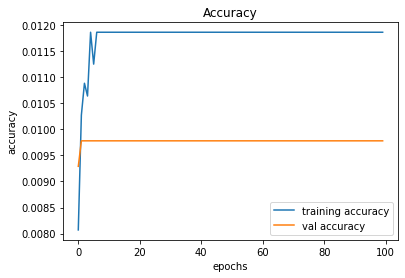

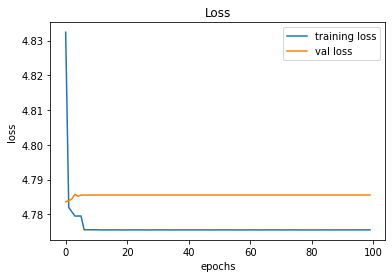

In [19]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [20]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                rescale=1./255,
                                                                rotation_range=30,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                #vertical_flip=True,
                                                                fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [21]:
training_data = train_datagen.flow(x_train,np.asarray(y_train),batch_size=BATCH)
testing_data = test_datagen.flow(x_val,np.asarray(y_val),batch_size=BATCH)

In [22]:
model2 = Sequential()
model2.add(ZeroPadding2D((1,1),input_shape=(IMG_SIZE,IMG_SIZE,channels)))
model2.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(ZeroPadding2D((1,1)))

model2.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=500,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=120,activation='softmax'))

model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 130, 130, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)       

In [23]:
history = model2.fit(training_data,
                     epochs=EPOCHS,
                     steps_per_epoch= 8177//BATCH,  #Number of training images//batch_size
                     validation_data=testing_data,
                     validation_steps = 2045//BATCH, #Number of test images//batch_size
                     callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/100
81/81 [==============================] - 18s 198ms/step - loss: 4.7872 - accuracy: 0.0100 - val_loss: 4.7855 - val_accuracy: 0.0095

Epoch 00001: val_accuracy did not improve from 0.00978
Epoch 2/100
81/81 [==============================] - 15s 183ms/step - loss: 4.7817 - accuracy: 0.0107 - val_loss: 4.7830 - val_accuracy: 0.0100

Epoch 00002: val_accuracy improved from 0.00978 to 0.01000, saving model to dogbreed_cnn.h5
Epoch 3/100
81/81 [==============================] - 15s 182ms/step - loss: 4.7784 - accuracy: 0.0133 - val_loss: 4.7837 - val_accuracy: 0.0110

Epoch 00003: val_accuracy improved from 0.01000 to 0.01100, saving model to dogbreed_cnn.h5
Epoch 4/100
81/81 [==============================] - 15s 184ms/step - loss: 4.7777 - accuracy: 0.0091 - val_loss: 4.7849 - val_accuracy: 0.0110

Epoch 00004: val_accuracy did not improve from 0.01100
Epoch 5/100
81/81 [==============================] - 15s 185ms/step - loss: 4.7779 - accuracy: 0.0106 - val_loss: 4.7850 - val

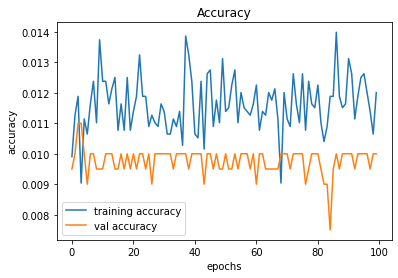

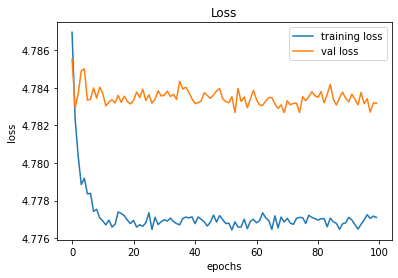

In [24]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [25]:
channels=3

In [26]:
x_features=[]
label=[]

for f, img in tqdm(labels.values): #f for image id, img for dog breed
  #Using cv2.imread results in BGR images, instead of the standard RGB as below
  train_img = cv2.imread('./train/{}.jpg'.format(f),1) #0 for grayscale & 1 for color (o/p is bgr)
  train_img_resize = cv2.resize(train_img, (IMG_SIZE,IMG_SIZE))
  x_features.append(train_img_resize)
  label.append(img)

100%|██████████| 10222/10222 [00:26<00:00, 383.97it/s]


In [27]:
label = encoder.fit_transform(label)
y_label=tf.keras.utils.to_categorical(label, num_classes=None, dtype='int')#, 120)

In [28]:
x_features = np.array(x_features,np.float32) / 255.0  #Division by 255. for normalisation
print(x_features.shape)

y_label = np.array(y_label)
print(y_label.shape)

(10222, 128, 128, 3)
(10222, 120)


In [29]:
x_train,x_val,y_train,y_val=train_test_split(x_features,y_label,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_val.shape)

(8177, 128, 128, 3)
(2045, 128, 128, 3)


In [30]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                rescale=1./255,
                                                                rotation_range=30,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                #vertical_flip=True,
                                                                fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                                               rescale=1./255)

In [31]:
training_data = train_datagen.flow(x_train,np.asarray(y_train),batch_size=BATCH)
testing_data = test_datagen.flow(x_val,np.asarray(y_val),batch_size=BATCH)

In [32]:
#Download the VGG weight file from here
#https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [33]:
base_model = VGG16(weights='/content/drive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False, pooling='avg')

for layers in base_model.layers:
  layers.trainable=False

In [34]:
x=base_model.output
x=tf.keras.layers.Dense(2048,activation='relu')(x)
x=tf.keras.layers.Dropout(rate=0.2)(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(rate=0.2)(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dropout(rate=0.2)(x)
x=tf.keras.layers.Dense(120,activation='softmax')(x)
model3=tf.keras.Model(inputs=base_model.input,outputs=x)
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [35]:
history = model3.fit(x_train,np.asarray(y_train),
                     validation_data=(x_val,np.asarray(y_val)),
                     epochs=EPOCHS,
                     batch_size=BATCH,
                     #callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/100
82/82 [==============================] - 17s 182ms/step - loss: 4.8256 - accuracy: 0.0100 - val_loss: 4.6399 - val_accuracy: 0.0308
Epoch 2/100
82/82 [==============================] - 13s 154ms/step - loss: 4.4845 - accuracy: 0.0417 - val_loss: 4.1024 - val_accuracy: 0.0748
Epoch 3/100
82/82 [==============================] - 13s 155ms/step - loss: 3.9676 - accuracy: 0.0894 - val_loss: 3.7254 - val_accuracy: 0.1315
Epoch 4/100
82/82 [==============================] - 13s 155ms/step - loss: 3.5955 - accuracy: 0.1389 - val_loss: 3.5502 - val_accuracy: 0.1399
Epoch 5/100
82/82 [==============================] - 13s 155ms/step - loss: 3.3812 - accuracy: 0.1670 - val_loss: 3.4155 - val_accuracy: 0.1545
Epoch 6/100
82/82 [==============================] - 13s 156ms/step - loss: 3.2208 - accuracy: 0.1961 - val_loss: 3.3027 - val_accuracy: 0.1907
Epoch 7/100
82/82 [==============================] - 13s 156ms/step - loss: 3.0249 - accuracy: 0.2384 - val_loss: 3.2967 - val_accuracy:

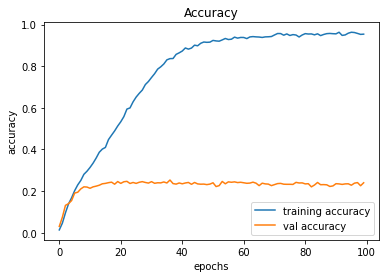

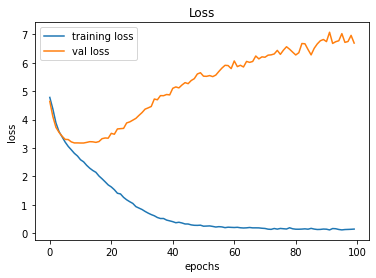

In [36]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
#model4=tf.keras.Model(inputs=base_model.input,outputs=x)
#model4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#history = model4.fit(training_data,epochs=EPOCHS,steps_per_epoch= 8177//BATCH,  #Number of training images//batch_size
                     #validation_data=testing_data, validation_steps = 2045//BATCH, #Number of test images//batch_size
                     #callbacks = [model_checkpoint,model_es,model_lr],verbose=1)